In [5]:
import numpy as np
from numpy import genfromtxt


#shuffler
def unison_shuffled_copies(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]



X_Dat=[]




for i in range(100): 
  daty = genfromtxt("Input/dat"+str(i+1)+".csv", delimiter=',')# My reference Image
  X_Dat.append(daty[:,:])

X_datnew=np.asarray(X_Dat)

X=X_datnew


##################################################################################

Y=np.zeros((100,9))

for i in range(100):
  my_data = genfromtxt("Labels/lab"+str(i+1)+".csv", delimiter=',')
  Y[i,:]=my_data
    
    
###################################################################################

#Random Shuffling
X,Y=unison_shuffled_copies(X, Y)

# Split the dataset
split_train = int(len(X)*0.7)
split_valid = int(len(X)*0.9)

# Train

X_train = X[:split_train, :]; y_train=Y[:split_train, :]

# Valid

X_valid = X[split_train:split_valid,:]; y_valid=Y[split_train:split_valid,:]

# Test

X_test = X[split_valid:,:]; y_test=Y[split_valid:,:]

   
print(X_train.shape, y_train.shape)
print(X_valid.shape, y_valid.shape)
print(X_test.shape, y_test.shape)

(70, 201, 9) (70, 9)
(20, 201, 9) (20, 9)
(10, 201, 9) (10, 9)


In [2]:
import numpy as np


from tensorflow import keras
from tensorflow.keras import layers

In [94]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Normalization and Attention
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    # Feed Forward Part
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res

In [104]:
out_dim=y_train.shape[1]
def build_model(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0,
    mlp_dropout=0,
):
    inputs = keras.Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="linear")(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(out_dim, activation="linear")(x)
    return keras.Model(inputs, outputs)

In [112]:
input_shape = X_train.shape[1:]

model = build_model(
    input_shape,
    head_size=256*2,
    num_heads=4,
    ff_dim=4,
    num_transformer_blocks=2,
    mlp_units=[128],
    mlp_dropout=0.4,
    dropout=0.1,
)

model.compile(
    loss="mse",
    optimizer=keras.optimizers.Adam(learning_rate=1e-2),
    metrics=["accuracy"],
)
model.summary()

callbacks = [keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)]

history=model.fit(
    X_train,
    y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=1,
    verbose=1
    # callbacks=callbacks,
)

# model.evaluate(X_test, y_test, verbose=1)

Model: "model_24"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_27 (InputLayer)          [(None, 201, 9)]     0           []                               
                                                                                                  
 layer_normalization_90 (LayerN  (None, 201, 9)      18          ['input_27[0][0]']               
 ormalization)                                                                                    
                                                                                                  
 multi_head_attention_45 (Multi  (None, 201, 9)      79881       ['layer_normalization_90[0][0]', 
 HeadAttention)                                                   'layer_normalization_90[0][0]'] 
                                                                                           

Text(0.5, 1.0, 'Training and validation loss')

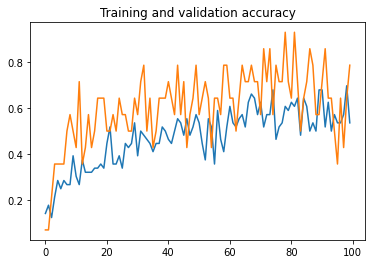

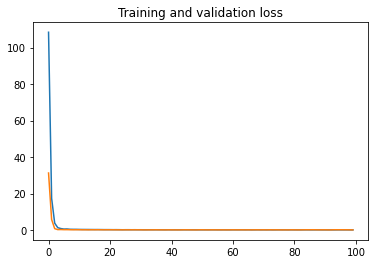

In [113]:
%matplotlib inline

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure


acc = history.history['accuracy']
val_acc = history.history['val_accuracy']


loss = history.history['loss']
val_loss = history.history['val_loss']


epochs = range(len(acc))

plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
plt.title('Training and validation accuracy')

plt.figure()

plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.title('Training and validation loss')

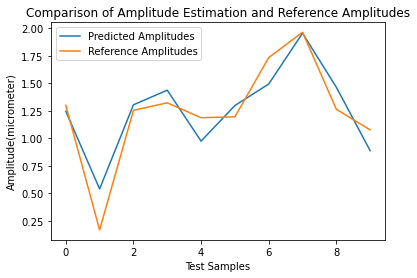

In [114]:
y_predictim=model.predict(X_test)


plt.plot(y_predictim[:,0],label="Predicted Amplitudes")
plt.plot(y_test[:,0],label="Reference Amplitudes")
plt.legend(loc="upper left")
plt.xlabel('Test Samples')
plt.ylabel('Amplitude(micrometer)')
plt.title('Comparison of Amplitude Estimation and Reference Amplitudes')
plt.show()

In [115]:
from sklearn.metrics import mean_absolute_error


print("Mean Absolute Error Achieved: ")
print(((mean_absolute_error(y_test, y_predictim))))

Mean Absolute Error Achieved: 
0.26498628972014143


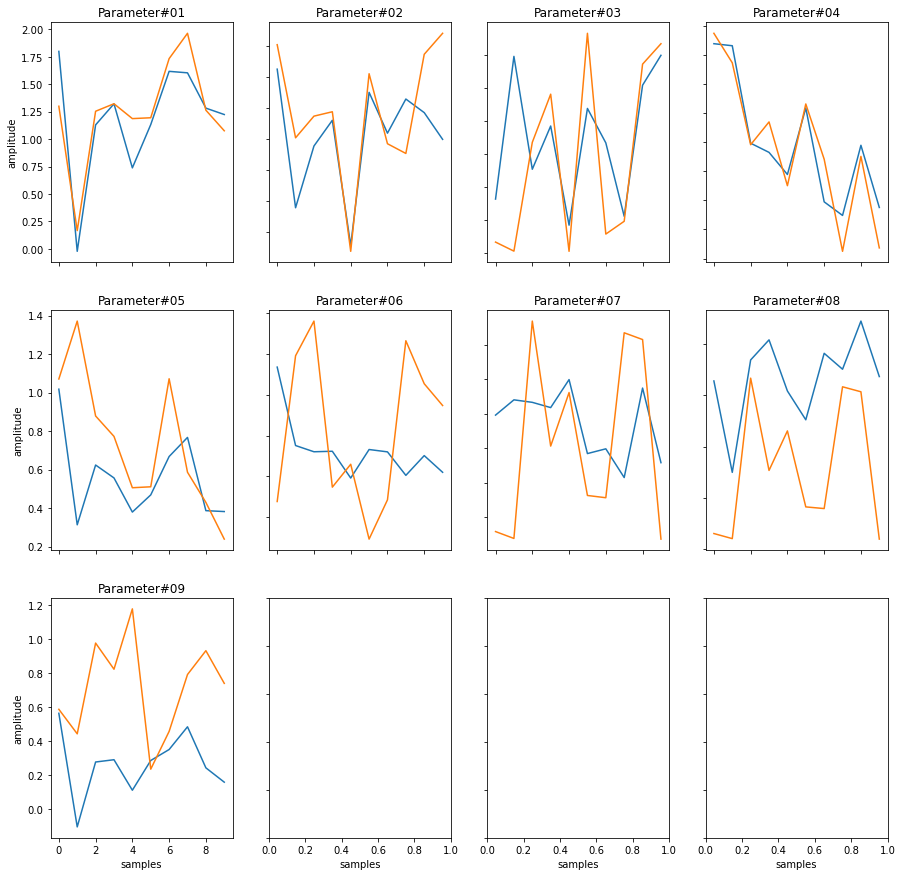

In [93]:
fig, axs = plt.subplots(3, 4,figsize=(15,15))

axs[0, 0].plot(y_predictim[:,0],label="Predicted Amplitudes")
axs[0,0].plot(y_test[:,0],label="Reference Amplitudes")
axs[0, 0].set_title('Parameter#01')
axs[0, 1].plot(y_predictim[:,1],label="Predicted Amplitudes")
axs[0,1].plot(y_test[:,1],label="Reference Amplitudes")
axs[0, 1].set_title('Parameter#02')
axs[0, 2].plot(y_predictim[:,2],label="Predicted Amplitudes")
axs[0,2].plot(y_test[:,2],label="Reference Amplitudes")
axs[0,2].set_title('Parameter#03')
axs[0, 3].plot(y_predictim[:,3],label="Predicted Amplitudes")
axs[0,3].plot(y_test[:,3],label="Reference Amplitudes")
axs[0,3].set_title('Parameter#04')
axs[1, 0].plot(y_predictim[:,4],label="Predicted Amplitudes")
axs[1,0].plot(y_test[:,4],label="Reference Amplitudes")
axs[1, 0].set_title('Parameter#05')
axs[1, 1].plot(y_predictim[:,5],label="Predicted Amplitudes")
axs[1,1].plot(y_test[:,5],label="Reference Amplitudes")
axs[1, 1].set_title('Parameter#06')
axs[1, 2].plot(y_predictim[:,6],label="Predicted Amplitudes")
axs[1,2].plot(y_test[:,6],label="Reference Amplitudes")
axs[1, 2].set_title('Parameter#07')
axs[1, 3].plot(y_predictim[:,7],label="Predicted Amplitudes")
axs[1,3].plot(y_test[:,6],label="Reference Amplitudes")
axs[1,3].set_title('Parameter#08')
axs[2, 0].plot(y_predictim[:,8],label="Predicted Amplitudes")
axs[2,0].plot(y_test[:,7],label="Reference Amplitudes")
axs[2,0].set_title('Parameter#09')


for ax in axs.flat:
    ax.set(xlabel='samples', ylabel='amplitude')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()